# Installation

- `pip install -r requirements.txt`

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys
import os

# Add the path to the folder containing utils.py
sys.path.append(os.path.abspath('../app/helpers'))

import importlib
import metric_utils
importlib.reload(metric_utils)

<module 'metric_utils' from 'c:\\Users\\whjw1\\Documents\\GitHub\\PythonProjectsDirectory\\StockmarketTechnicalAnalyzer\\app\\helpers\\metric_utils.py'>

# Data Retrieval

Possible user inputs are:

- `tickers`
- `start_date`
- `end_date`

[What are the stock sectors?](https://www.schwab.com/learn/story/what-are-stock-sectors)

| Ticker | Company | Sector |
|:---|:---| :---|
| KO | Coca-Cola | Consumer Staples |
| PEP | Pepsi | Consumer Staples |
| WMT | Walmart | Consumer Staples |
| SBUX | Starbucks | Consumer Discretionary |
| MCD | McDonald's | Consumer Discretionary |
| AAL | American Airlines | Industrials |
| DAL | Delta Airlines | Industrials |
| F | Ford Motors | Industrials |
| VZ | Verizon | Communication Services |
| T | AT&T | Communication Services |
| DIS | Disney | Communication Services |
| BAC | Bank of America | Financials |
| JPM | JP Morgan | Financials |
| MA | Mastercard | Financials |
| V | Visa | Financials |
| ORCL | Oracle | Information Technology |
| AMD | AMD | Information Technology |
| NVDA | Nvidia | Information Technology |
| AAPL | Apple | Information Technology |
| MSFT | Microsoft | Information Technology |

In [2]:
# user to decide this parameters
TICKERS = [
    'KO','PEP','WMT', # consumer staples
    'SBUX','MCD', # consumer discretionary
    'AAL','DAL','F', # industrials
    'VZ', 'T', 'DIS', # communication services
    'BAC','JPM','MA','V', # financials
    'ORCL','AMD','NVDA','AAPL','MSFT', # information technology
] 
START_DATE = "2000-01-01"
END_DATE = "2024-07-31"

Documentation: [yfinance](https://github.com/ranaroussi/yfinance/wiki/Tickers#parameters)

In [3]:
df = yf.download(tickers=TICKERS, interval="1d", start=START_DATE, end=END_DATE, auto_adjust=True, group_by='ticker')
df.head() # see how the raw data format looks

[*********************100%***********************]  20 of 20 completed


Ticker                     DAL                          V                 \
Price                     Open High Low Close Volume Open High Low Close   
Date                                                                       
2000-01-03 00:00:00+00:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   
2000-01-04 00:00:00+00:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   
2000-01-05 00:00:00+00:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   
2000-01-06 00:00:00+00:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   
2000-01-07 00:00:00+00:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   

Ticker                            ...        DIS                        \
Price                     Volume  ...       Open       High        Low   
Date                              ...                                    
2000-01-03 00:00:00+00:00    NaN  ...  22.454557  22.982335  22.070719   
2000-01-04 00:00:00+00:00    NaN  ...  23.030314  24.469710  23.030314   
2000-01-05 00:00:00+00:00    NaN  ...  24.277787  25.429303  24.277787   
2000-01-06 00:00:00+00:00    NaN  ...  25.285366  25.429307  24.277790   
2000-01-07 00:00:00+00:00    NaN  ...  24.277792  24.661630  23.654053   

Ticker                                                 T                      \
Price                          Close    Volume      Open      High       Low   
Date                                                                           
2000-01-03 00:00:00+00:00  22.934355   8402230  6.914800  6.977096  6.638920   
2000-01-04 00:00:00+00:00  24.277790  16051191  6.701214  6.799107  6.193950   
2000-01-05 00:00:00+00:00  25.285362  19823822  6.407535  6.443133  6.327441   
2000-01-06 00:00:00+00:00  24.277790   7903193  6.391187  6.453933  6.185019   
2000-01-07 00:00:00+00:00  23.893953   6773543  6.391187  6.418079  6.220875   

Ticker                                         
Price                         Close    Volume  
Date                                           
2000-01-03 00:00:00+00:00  6.692316   7668476  
2000-01-04 00:00:00+00:00  6.300743   9497846  
2000-01-05 00:00:00+00:00  6.398636  12035160  
2000-01-06 00:00:00+00:00  6.274657   9471366  
2000-01-07 00:00:00+00:00  6.328440   7792534  

[5 rows x 100 columns]

In [4]:
# reformat for easy read from store
df = df.stack(level='Ticker')
df.columns = [s.lower() for s in df.columns]
df.index.names = [s.lower() for s in df.index.names]
df.reset_index(inplace=True)
df.head()

C:\Users\whjw1\AppData\Local\Temp\ipykernel_13152\4229889244.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level='Ticker')


,date,ticker,open,high,low,close,volume
0,2000-01-03 00:00:00+00:00,AAPL,0.790753,0.848245,0.766719,0.844004,535796800.0
1,2000-01-03 00:00:00+00:00,AMD,14.968750,15.593750,14.687500,15.500000,7843200.0
2,2000-01-03 00:00:00+00:00,BAC,13.263150,13.263150,12.669278,12.784753,13705800.0
3,2000-01-03 00:00:00+00:00,DIS,22.454557,22.982335,22.070719,22.934355,8402230.0
4,2000-01-03 00:00:00+00:00,F,12.593087,12.697532,12.443880,12.503563,4056814.0


In [5]:
# download the benchmark data for reference later
spy = yf.download(tickers='SPY', interval="1d", start=START_DATE, end=END_DATE, auto_adjust=True)
spy.reset_index(inplace=True)
spy.columns = [c.lower() for c in spy.columns]
if not spy.isnull().sum().any():
    spy.to_csv('../app/static/data/spy.csv', index=False)
    print("Saved to data/spy.csv")

[*********************100%***********************]  1 of 1 completed

Saved to data/spy.csv


In [6]:
spy = pd.read_csv('../app/static/data/spy.csv', parse_dates=['date'])
spy.set_index('date', inplace=True)
spy

,open,high,low,close,volume
date,,,,,
2000-01-03,94.803461,94.803461,92.005720,93.004913,8164300
2000-01-04,91.785907,92.125633,89.297915,89.367859,8089800
2000-01-05,89.487735,90.506912,87.769122,89.527702,12177900
2000-01-06,89.287868,90.486899,88.088837,88.088837,6227200
2000-01-07,89.727579,93.204773,89.567708,93.204773,8066500
...,...,...,...,...,...
2024-07-24,547.181624,547.490674,538.637823,539.574951,74515300
2024-07-25,539.694562,545.785924,535.806524,536.763550,61158300
2024-07-26,540.621778,545.516737,539.834155,542.775146,53763800


In [7]:
# just a performance statistic of buying and holding the S&P 500 for the entire period
metric_utils.benchmark_performance(spy, START_DATE, END_DATE)

======================= BENCHMARK BUY-N-HOLD PERFORMANCE =======================
Trading Days: 6181
'Up' days: 3357 (54.31%)
'Down' days: 2803 (45.35%)
Total Return: 480.98%
Annualised Volatility: 19.47%
Maximum Drawdown: -55.19%
Profit Factor: 1.073
Average Profit: 0.008
Average Loss: 0.009
Benchmark performance dict = {'trade_days': '6181', 'up_days': '3357', 'up_days_percentage': '54.31', 'down_days': '2803', 'down_days_percentage': '45.35', 'total_return': '480.98', 'annualised_volatility': '19.47', 'maximum_drawdown': '-55.19', 'profit_factor': '1.073', 'average_profit': '0.008', 'average_loss_display': '0.009'}


{'trade_days': '6181',
 'up_days': '3357',
 'up_days_percentage': '54.31',
 'down_days': '2803',
 'down_days_percentage': '45.35',
 'total_return': '480.98',
 'annualised_volatility': '19.47',
 'maximum_drawdown': '-55.19',
 'profit_factor': '1.073',
 'average_profit': '0.008',
 'average_loss_display': '0.009'}

# Data Cleaning

Check for any missing values before storing for further processing.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116687 entries, 0 to 116686
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   date    116687 non-null  datetime64[ns, UTC]
 1   ticker  116687 non-null  object             
 2   open    116687 non-null  float64            
 3   high    116687 non-null  float64            
 4   low     116687 non-null  float64            
 5   close   116687 non-null  float64            
 6   volume  116687 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(1)
memory usage: 6.2+ MB


In [9]:
df.isnull().sum()

date      0
ticker    0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

No missing values to fill. Market holidays have been automatically excluded.

# Data Store

In [10]:
# format is just a csv file with column names above
df.to_csv('../app/static/data/ohlcv.csv', index=False)

# Data Processing

Construct the indicators' values for each stock.

In [11]:
# load the data into proper format for processing
df = pd.read_csv('../app/static/data/ohlcv.csv', parse_dates=['date'])
df.set_index(['date', 'ticker'], inplace=True)
df.head()

open       high        low      close  \
date                      ticker                                               
2000-01-03 00:00:00+00:00 AAPL     0.790753   0.848245   0.766719   0.844004   
                          AMD     14.968750  15.593750  14.687500  15.500000   
                          BAC     13.263150  13.263150  12.669278  12.784753   
                          DIS     22.454557  22.982335  22.070719  22.934355   
                          F       12.593087  12.697532  12.443880  12.503563   

                                       volume  
date                      ticker               
2000-01-03 00:00:00+00:00 AAPL    535796800.0  
                          AMD       7843200.0  
                          BAC      13705800.0  
                          DIS       8402230.0  
                          F         4056814.0

Documentation: [pandas-ta](https://twopirllc.github.io/pandas-ta/)

In [12]:
def contruct_indicators(group):

    # indicator: Simple Moving Averages
    group['sma_5'] = ta.sma(group['close'], length=5)
    group['sma_10'] = ta.sma(group['close'], length=10)
    group['sma_21'] = ta.sma(group['close'], length=21)
    group['sma_50'] = ta.sma(group['close'], length=50)
    group['sma_100'] = ta.sma(group['close'], length=100)
    group['sma_200'] = ta.sma(group['close'], length=200)

    # indicator: Exponential Moving Averages
    group['ema_5'] = ta.ema(group['close'], length=5)
    group['ema_10'] = ta.ema(group['close'], length=10)
    group['ema_21'] = ta.ema(group['close'], length=21)
    group['ema_50'] = ta.ema(group['close'], length=50)
    group['ema_100'] = ta.ema(group['close'], length=100)
    group['ema_200'] = ta.ema(group['close'], length=200)

    # indicator: normalized volume
    group['norm_volume_3'] = group['volume'] / group['volume'].rolling(3).median()
    group['norm_volume_5'] = group['volume'] / group['volume'].rolling(5).median()
    group['norm_volume_10'] = group['volume'] / group['volume'].rolling(10).median()
    group['norm_volume_21'] = group['volume'] / group['volume'].rolling(21).median()
    group['norm_volume_50'] = group['volume'] / group['volume'].rolling(50).median()

    # indicator: Relative Strength Index
    group['rsi_7'] = ta.rsi(group['close'], length=7)
    group['rsi_9'] = ta.rsi(group['close'], length=9)
    group['rsi_10'] = ta.rsi(group['close'], length=10)
    group['rsi_14'] = ta.rsi(group['close'], length=14)
    

    # indicator: Average Directional Index
    adx_result = ta.adx(group['high'], group['low'], group['close'], length=3)
    group['adx_3'] = adx_result['ADX_3']
    group['+DI_3'] = adx_result['DMP_3']  # +DI
    group['-DI_3'] = adx_result['DMN_3']  # -DI

    adx_result = ta.adx(group['high'], group['low'], group['close'], length=5)
    group['adx_5'] = adx_result['ADX_5']
    group['+DI_5'] = adx_result['DMP_5']  # +DI
    group['-DI_5'] = adx_result['DMN_5']  # -DI

    adx_result = ta.adx(group['high'], group['low'], group['close'], length=7)
    group['adx_7'] = adx_result['ADX_7']
    group['+DI_7'] = adx_result['DMP_7']  # +DI
    group['-DI_7'] = adx_result['DMN_7']  # -DI

    adx_result = ta.adx(group['high'], group['low'], group['close'], length=14)
    group['adx_14'] = adx_result['ADX_14']
    group['+DI_14'] = adx_result['DMP_14']  # +DI
    group['-DI_14'] = adx_result['DMN_14']  # -DI

    # indicator: Bollinger Bands
    bband_result = ta.bbands(group['close'])
    group['bb_5_lb'] = bband_result['BBL_5_2.0']
    group['bb_5_mb'] = bband_result['BBM_5_2.0']
    group['bb_5_ub'] = bband_result['BBU_5_2.0']
    group['bb_5_bw'] = bband_result['BBB_5_2.0']
    group['bb_5_p'] = bband_result['BBP_5_2.0']

    return group

def log_returns(group, periods=[1]):
    # daily log return
    group['log_return'] = np.log(group['close']) -  np.log(group['close'].shift(1))
    return group

In [13]:
df_returns = df.groupby('ticker', group_keys=False).apply(log_returns)
df_indicators = df_returns.groupby('ticker', group_keys=False).apply(contruct_indicators)
df_indicators

open        high         low  \
date                      ticker                                       
2000-01-03 00:00:00+00:00 AAPL      0.790753    0.848245    0.766719   
                          AMD      14.968750   15.593750   14.687500   
                          BAC      13.263150   13.263150   12.669278   
                          DIS      22.454557   22.982335   22.070719   
                          F        12.593087   12.697532   12.443880   
...                                      ...         ...         ...   
2024-07-30 00:00:00+00:00 SBUX     74.797930   75.593127   74.400332   
                          T        18.950001   19.030001   18.840000   
                          V       262.703201  263.771036  260.487642   
                          VZ       40.009998   40.259998   39.830002   
                          WMT      69.352317   69.651460   68.783937   

                                       close       volume  log_return  \
date                      ticker                                        
2000-01-03 00:00:00+00:00 AAPL      0.844004  535796800.0         NaN   
                          AMD      15.500000    7843200.0         NaN   
                          BAC      12.784753   13705800.0         NaN   
                          DIS      22.934355    8402230.0         NaN   
                          F        12.503563    4056814.0         NaN   
...                                      ...          ...         ...   
2024-07-30 00:00:00+00:00 SBUX     75.483788   16163600.0    0.009792   
                          T        18.980000   27855000.0    0.004224   
                          V       262.573456    5941800.0    0.005717   
                          VZ       40.040001   16089200.0    0.000250   
                          WMT      68.993340   12522500.0   -0.006196   

                                       sma_5      sma_10      sma_21  \
date                      ticker                                       
2000-01-03 00:00:00+00:00 AAPL           NaN         NaN         NaN   
                          AMD            NaN         NaN         NaN   
                          BAC            NaN         NaN         NaN   
                          DIS            NaN         NaN         NaN   
                          F              NaN         NaN         NaN   
...                                      ...         ...         ...   
2024-07-30 00:00:00+00:00 SBUX     74.189606   75.002691   74.646463   
                          T        19.048000   18.943000   18.783862   
                          V       257.896838  262.661288  264.399798   
                          VZ       39.956000   40.348000   40.647419   
                          WMT      69.643486   70.084230   69.577865   

                                      sma_50  ...      +DI_7      -DI_7  \
date                      ticker              ...                         
2000-01-03 00:00:00+00:00 AAPL           NaN  ...        NaN        NaN   
                          AMD            NaN  ...        NaN        NaN   
                          BAC            NaN  ...        NaN        NaN   
                          DIS            NaN  ...        NaN        NaN   
                          F              NaN  ...        NaN        NaN   
...                                      ...  ...        ...        ...   
2024-07-30 00:00:00+00:00 SBUX     77.282909  ...  20.559954  18.754751   
                          T        18.150410  ...  30.605931  20.805907   
                          V       269.264647  ...  22.747216  25.688501   
                          VZ       40.100252  ...  29.096968  25.778490   
                          WMT      67.662334  ...  11.174293  25.683480   

                                     adx_14     +DI_14     -DI_14     bb_5_lb  \
date                      ticker                                                
2000-01-03 00:00:00+00:00 AAPL          NaN        NaN        NaN         NaN 

# Data Analysis and Visualization

In this section, we attempt to identify possible patterns from the technical indicators e.g. Moving Average Crossover. \
For it to be meaningful, we analyse the signals generated by the indicators with respect to future returns over some period.

Possible WebApp Framework for Interactive Visualisation: [Dash](https://dash.plotly.com/?_gl=1*ta35r5*_gcl_au*Mjk1MjQ3NTI2LjE3MjY5MjA3ODU.*_ga*Nzk0MzAyNTg4LjE3MjY5MjA3ODY.*_ga_6G7EE0JNSC*MTcyNjkyMDc4NS4xLjAuMTcyNjkyMDc4NS42MC4wLjA)

Difference between Dash and Plotly: [here](https://stackoverflow.com/questions/53146357/whats-the-difference-between-dash-and-plotly)

In [14]:
# possibly a dropdown to let user select ticker to visualize
TICKER = 'KO'
data = df_indicators.xs(level='ticker', key=TICKER)
data

,open,high,low,close,volume,log_return,sma_5,sma_10,sma_21,sma_50,...,+DI_7,-DI_7,adx_14,+DI_14,-DI_14,bb_5_lb,bb_5_mb,bb_5_ub,bb_5_bw,bb_5_p
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,14.530039,14.530039,13.841115,14.122948,10997000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04 00:00:00+00:00,14.122948,14.232549,13.935059,14.138605,7308000.0,0.001108,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00+00:00,14.138609,14.389127,14.044665,14.263868,9457400.0,0.008821,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06 00:00:00+00:00,14.263859,14.451747,14.169915,14.279516,7129200.0,0.001096,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07 00:00:00+00:00,14.498717,15.218956,14.498717,15.218956,11474000.0,0.063716,14.404779,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13.580784,14.404779,15.228773,11.440568,0.994043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24 00:00:00+00:00,64.646802,65.520815,64.388577,65.361900,13244600.0,0.013000,64.760028,64.131339,63.524500,62.724648,...,29.265304,9.634904,23.045818,28.192967,12.158041,64.059018,64.760028,65.461038,2.164946,0.929289
2024-07-25 00:00:00+00:00,65.590338,66.434549,65.411563,65.620132,16328600.0,0.003943,64.934830,64.426316,63.629967,62.783833,...,38.025245,8.125572,24.954946,33.120380,11.106880,63.954594,64.934830,65.915065,3.019136,0.849560
2024-07-26 00:00:00+00:00,65.620130,66.653049,65.560541,66.593460,13530100.0,0.014724,65.284433,64.759035,63.771851,62.871945,...,35.196473,6.850403,26.875231,31.983903,10.144820,63.651514,65.284433,66.917352,5.002475,0.900824


### Strategy 1: EMA Crossover

EMA(21) crossing over the EMA(50) is generally seen as a bullish signal.

This strategy simply takes a long position when it occurs and holds it for K number of days (profiting/losing the K-day returns).

In [15]:
DEFAULT_COLUMNS = ['open', 'high', 'low', 'close']

In [16]:
# required indicators
strategy = data[DEFAULT_COLUMNS + ['rsi_14', 'log_return','ema_21', 'ema_50']].dropna().copy()
# strategy signal
strategy['signal'] = (strategy ['ema_21'] > strategy['ema_50']).astype(np.int32)

In [17]:
strategy['2d_log_return'] = strategy['log_return'].rolling(2).sum()
strategy['3d_log_return'] = strategy['log_return'].rolling(3).sum()
strategy['4d_log_return'] = strategy['log_return'].rolling(4).sum()
strategy['5d_log_return'] = strategy['log_return'].rolling(5).sum()
strategy['7d_log_return'] = strategy['log_return'].rolling(7).sum()
strategy['10d_log_return'] = strategy['log_return'].rolling(10).sum()
strategy.dropna(inplace=True)

In [18]:
K = 7 # can change the number here as desired
strategy['target'] = strategy[f'{K}d_log_return'].shift(-K)  
strategy.dropna(inplace=True)
strategy['log_returns'] = (strategy['signal'] * strategy['target'])
strategy['returns'] = np.exp(strategy.log_returns) - 1

In [20]:
# print the performance statistic of the strategy and the buy-and-hold
start_date = '2010-01-01'
end_date = '2022-12-31'
metric_utils.benchmark_performance(data, start_date, end_date)
metric_utils.strategy_peformance(strategy.loc[start_date:end_date])

======================= BENCHMARK BUY-N-HOLD PERFORMANCE =======================
Trading Days: 3271
'Up' days: 1723 (52.68%)
'Down' days: 1514 (46.29%)
Total Return: 233.36%
Annualised Volatility: 17.55%
Maximum Drawdown: -36.99%
Profit Factor: 1.103
Average Profit: 0.008
Average Loss: 0.008
Benchmark performance dict = {'trade_days': '3271', 'up_days': '1723', 'up_days_percentage': '52.68', 'down_days': '1514', 'down_days_percentage': '46.29', 'total_return': '233.36', 'annualised_volatility': '17.55', 'maximum_drawdown': '-36.99', 'profit_factor': '1.103', 'average_profit': '0.008', 'average_loss_display': '0.008'}
=========================== STRATEGY PERFORMANCE ===========================
Trades: 2183
'Up' days: 1234 (56.53%)
'Down' days: 937 (42.92%)
Total Return: 752.14%
Annualised Volatility: 33.73%
Maximum Drawdown: -80.27%
Profit Factor: 1.107
Average Profit: 0.018
Average Loss: 0.021
Strategy performance dict = {'trades': '2183', 'up_days': '1234', 'up_days_percentage': '56.5

{'trades': '2183',
 'up_days': '1234',
 'up_days_percentage': '56.53',
 'down_days': '937',
 'down_days_percentage': '42.92',
 'total_return': '752.14',
 'annualised_volatility': '33.73',
 'maximum_drawdown': '-80.27',
 'profit_factor': '1.107',
 'average_profit': '0.018',
 'average_loss_display': '0.021'}

In [21]:
strategy

,open,high,low,close,rsi_14,log_return,ema_21,ema_50,signal,2d_log_return,3d_log_return,4d_log_return,5d_log_return,7d_log_return,10d_log_return,target,log_returns,returns
date,,,,,,,,,,,,,,,,,,
2000-03-27 00:00:00+00:00,11.818502,11.849934,11.378451,11.378451,37.759824,-0.037945,12.139160,13.315841,0,-0.037945,-0.039274,-0.088507,-0.070649,-0.094807,0.033711,0.051155,0.000000,0.000000
2000-03-28 00:00:00+00:00,11.378444,11.692765,11.284147,11.284147,36.854194,-0.008322,12.061432,13.236167,0,-0.046267,-0.046267,-0.047596,-0.096829,-0.090488,0.035439,0.019312,0.000000,0.000000
2000-03-29 00:00:00+00:00,11.394164,11.834215,11.394164,11.787066,44.499121,0.043604,12.036490,13.179340,0,0.035282,-0.002663,-0.002663,-0.003992,-0.035367,-0.014560,-0.014774,-0.000000,0.000000
2000-03-30 00:00:00+00:00,11.849930,12.557154,11.849930,12.211400,49.999550,0.035367,12.052390,13.141381,0,0.078971,0.070649,0.032704,0.032704,-0.017858,-0.024159,-0.076188,-0.000000,0.000000
2000-03-31 00:00:00+00:00,12.211400,12.242833,11.802782,11.802782,45.339718,-0.034035,12.029699,13.088887,0,0.001332,0.044936,0.036614,-0.001331,-0.002660,-0.045551,0.005312,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15 00:00:00+00:00,63.355658,63.504635,62.918652,62.978245,54.227232,-0.004563,62.720492,62.091749,1,0.004901,0.009189,0.011420,0.007122,0.001262,-0.003778,0.037150,0.037150,0.037849
2024-07-16 00:00:00+00:00,62.998109,63.872115,62.958381,63.832386,61.780515,0.013471,62.821573,62.160009,1,0.008908,0.018372,0.022660,0.024891,0.007967,0.015524,0.027622,0.027622,0.028007
2024-07-17 00:00:00+00:00,64.031032,64.944766,63.971443,64.765991,67.996913,0.014520,62.998339,62.262205,1,0.027991,0.023428,0.032892,0.037180,0.035113,0.032100,0.027826,0.027826,0.028216


In [23]:
###
start_date = '2010-01-01'
end_date = '2022-12-31'
metric_utils.visualise_pricechart(strategy, start=start_date, end=end_date, indicators=['EMA'], signal_marker=True)

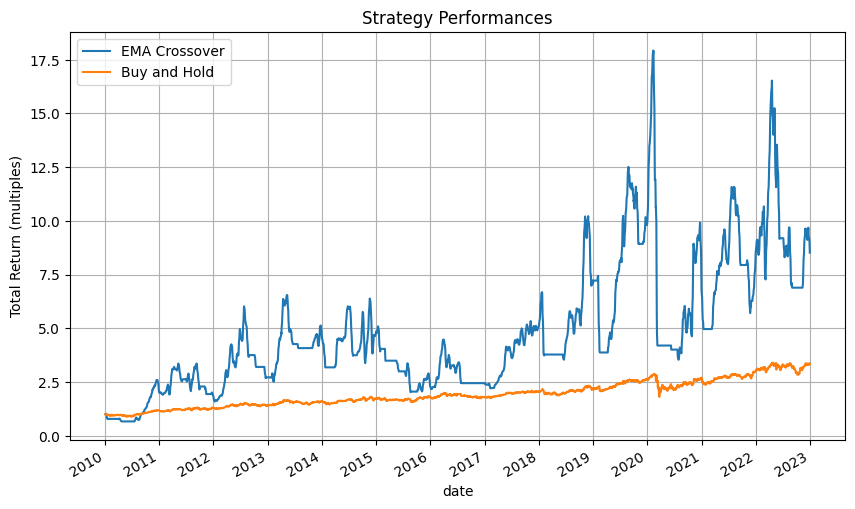

In [24]:
# visualize the performance of the strategy
ax = (strategy.loc[start_date:end_date].returns + 1).cumprod().plot(kind='line', label='EMA Crossover', title='Strategy Performances', ylabel='Total Return (multiples)', figsize=(10,6))
(np.exp(strategy.loc[start_date:end_date].log_return.cumsum())).plot(kind='line', label='Buy and Hold', grid=True, ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # set ticks for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # format of the year label
plt.legend(loc='upper left');

### Strategy 2: EMA Crossover + RSI

Additional and RSI value below (above) 30 (70) is generally seen as oversold (overbought).

A moving from below 30 (above 70) to above (below) it is seen as a bullish (bearish indicator). We try to overlay these two indicators to improve performance.

In [25]:
# required indicators
strategy = data[DEFAULT_COLUMNS + 
    [
        'volume', 'log_return',
        'ema_5', 'ema_10','ema_21', 'ema_50',
        'rsi_7', 'rsi_9', 'rsi_10', 'rsi_14',
    ]
].dropna()

K = 7 # using the same K=7 as before
RSI_K = 14

# strategy idea
# by adding more indicators as a filters, we should expect lesser trades and perhaps less volatility than previous strategy
strategy['signal'] = (
    (strategy['ema_21'] > strategy['ema_50']) & 
    (strategy[f'rsi_{RSI_K}'] < 50)
).astype(np.int32)

strategy['target'] = strategy['log_return'].rolling(K).sum().shift(-K)
strategy.dropna(inplace=True)
strategy['log_returns'] = (strategy['signal'] * strategy['target'])
strategy['returns'] = np.exp(strategy.log_returns) - 1

In [26]:
strategy

,open,high,low,close,volume,log_return,ema_5,ema_10,ema_21,ema_50,rsi_7,rsi_9,rsi_10,rsi_14,signal,target,log_returns,returns
date,,,,,,,,,,,,,,,,,,
2000-03-14 00:00:00+00:00,11.001262,11.142707,10.781237,10.891250,11162000.0,-0.010051,11.314484,11.712072,12.369497,13.882521,17.554917,20.357816,21.477012,24.926586,0,0.081706,0.0,0.0
2000-03-15 00:00:00+00:00,10.938398,12.022808,10.938398,11.959944,22138200.0,0.093603,11.529637,11.757139,12.332265,13.807126,50.950648,47.034046,45.683461,42.582760,0,-0.011897,-0.0,0.0
2000-03-16 00:00:00+00:00,12.211397,12.541435,12.211397,12.510003,17610200.0,0.044966,11.856426,11.894024,12.348423,13.756258,60.547052,55.638049,53.824175,49.204558,0,-0.094807,-0.0,0.0
2000-03-17 00:00:00+00:00,12.510009,12.557157,12.258552,12.352848,14530800.0,-0.012642,12.021900,11.977446,12.348825,13.701223,56.840271,52.877195,51.379632,47.518398,0,-0.090488,-0.0,0.0
2000-03-20 00:00:00+00:00,12.321413,12.321413,12.085671,12.211400,6755200.0,-0.011517,12.085067,12.019983,12.336332,13.642798,53.406930,50.347486,49.147363,45.990770,0,-0.035367,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15 00:00:00+00:00,63.355658,63.504635,62.918652,62.978245,8207500.0,-0.004563,62.881610,62.839992,62.720492,62.091749,53.824539,53.678027,53.728757,54.227232,0,0.037150,0.0,0.0
2024-07-16 00:00:00+00:00,62.998109,63.872115,62.958381,63.832386,9025100.0,0.013471,63.198535,63.020427,62.821573,62.160009,67.275349,64.718510,63.848751,61.780515,0,0.027622,0.0,0.0
2024-07-17 00:00:00+00:00,64.031032,64.944766,63.971443,64.765991,12508200.0,0.014520,63.721020,63.337803,62.998339,62.262205,76.138904,72.715166,71.435929,67.996913,0,0.027826,0.0,0.0


In [28]:
# print the performance statistic of the strategy and the buy-and-hold
start_date = '2010-01-01'
end_date = '2022-12-31'
metric_utils.benchmark_performance(data, start_date, end_date)
metric_utils.strategy_peformance(strategy.loc[start_date:end_date])

======================= BENCHMARK BUY-N-HOLD PERFORMANCE =======================
Trading Days: 3271
'Up' days: 1723 (52.68%)
'Down' days: 1514 (46.29%)
Total Return: 233.36%
Annualised Volatility: 17.55%
Maximum Drawdown: -36.99%
Profit Factor: 1.103
Average Profit: 0.008
Average Loss: 0.008
Benchmark performance dict = {'trade_days': '3271', 'up_days': '1723', 'up_days_percentage': '52.68', 'down_days': '1514', 'down_days_percentage': '46.29', 'total_return': '233.36', 'annualised_volatility': '17.55', 'maximum_drawdown': '-36.99', 'profit_factor': '1.103', 'average_profit': '0.008', 'average_loss_display': '0.008'}
=========================== STRATEGY PERFORMANCE ===========================
Trades: 482
'Up' days: 285 (59.13%)
'Down' days: 195 (40.46%)
Total Return: 296.87%
Annualised Volatility: 18.36%
Maximum Drawdown: -58.56%
Profit Factor: 1.303
Average Profit: 0.021
Average Loss: 0.023
Strategy performance dict = {'trades': '482', 'up_days': '285', 'up_days_percentage': '59.13', 

{'trades': '482',
 'up_days': '285',
 'up_days_percentage': '59.13',
 'down_days': '195',
 'down_days_percentage': '40.46',
 'total_return': '296.87',
 'annualised_volatility': '18.36',
 'maximum_drawdown': '-58.56',
 'profit_factor': '1.303',
 'average_profit': '0.021',
 'average_loss_display': '0.023'}

In [29]:
###

metric_utils.visualise_pricechart(strategy, start=start_date, end=end_date, indicators=['EMA'], signal_marker=True)

<!-- Notice that the volatility and maximum drawndown is much lesser now, which is desirable.

But as this signal occurs rarely, the number of trades decreases a lot as well. 

Nonetheless, this strategy can be a great addition to an arsenal of strategies. -->

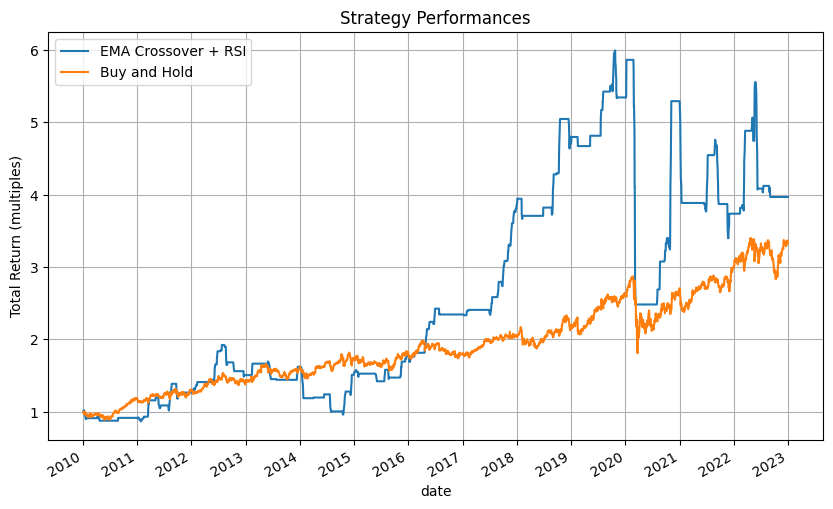

In [30]:
# visualize the performance of the strategy
ax = (strategy.loc[start_date:end_date].returns + 1).cumprod().plot(kind='line', label='EMA Crossover + RSI', title='Strategy Performances', ylabel='Total Return (multiples)', figsize=(10,6))
(np.exp(strategy.loc[start_date:end_date].log_return.cumsum())).plot(kind='line', label='Buy and Hold', grid=True, ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # set ticks for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # format of the year label
plt.legend(loc='upper left');

### Strategy 3: RSI + ADX

In [32]:
# required indicators
strategy = data[DEFAULT_COLUMNS + 
    [
        'volume', 'log_return',
        'rsi_7', 'rsi_9', 'rsi_10', 'rsi_14',
        'adx_3', 'adx_5', 'adx_7', 'adx_14',

    ]
].dropna()

K = 7 # using the same K=7 as before
RSI_K = 14
ADX_K = 14

# strategy idea
# by adding more indicators as a filters, we should expect lesser trades and perhaps less volatility
strategy['signal'] = (
    (strategy[f'rsi_{RSI_K}'] < 45) &
    (strategy[f'adx_{ADX_K}'] > 30)
).astype(np.int32)

strategy['target'] = strategy['log_return'].rolling(K).sum().shift(-K)
strategy.dropna(inplace=True)
strategy['log_returns'] = (strategy['signal'] * strategy['target'])
strategy['returns'] = np.exp(strategy.log_returns) - 1

In [33]:
# print the performance statistic of the strategy and the buy-and-hold
start_date = '2010-01-01'
end_date = '2022-12-31'
metric_utils.benchmark_performance(data, start_date, end_date)
metric_utils.strategy_peformance(strategy.loc[start_date:end_date])

======================= BENCHMARK BUY-N-HOLD PERFORMANCE =======================
Trading Days: 3271
'Up' days: 1723 (52.68%)
'Down' days: 1514 (46.29%)
Total Return: 233.36%
Annualised Volatility: 17.55%
Maximum Drawdown: -36.99%
Profit Factor: 1.103
Average Profit: 0.008
Average Loss: 0.008
Benchmark performance dict = {'trade_days': '3271', 'up_days': '1723', 'up_days_percentage': '52.68', 'down_days': '1514', 'down_days_percentage': '46.29', 'total_return': '233.36', 'annualised_volatility': '17.55', 'maximum_drawdown': '-36.99', 'profit_factor': '1.103', 'average_profit': '0.008', 'average_loss_display': '0.008'}
=========================== STRATEGY PERFORMANCE ===========================
Trades: 166
'Up' days: 115 (69.28%)
'Down' days: 51 (30.72%)
Total Return: 247.01%
Annualised Volatility: 19.55%
Maximum Drawdown: -83.50%
Profit Factor: 1.537
Average Profit: 0.031
Average Loss: 0.045
Strategy performance dict = {'trades': '166', 'up_days': '115', 'up_days_percentage': '69.28', '

{'trades': '166',
 'up_days': '115',
 'up_days_percentage': '69.28',
 'down_days': '51',
 'down_days_percentage': '30.72',
 'total_return': '247.01',
 'annualised_volatility': '19.55',
 'maximum_drawdown': '-83.50',
 'profit_factor': '1.537',
 'average_profit': '0.031',
 'average_loss_display': '0.045'}

In [34]:
metric_utils.visualise_pricechart(strategy, start=start_date, end=end_date, indicators=[], signal_marker=True)

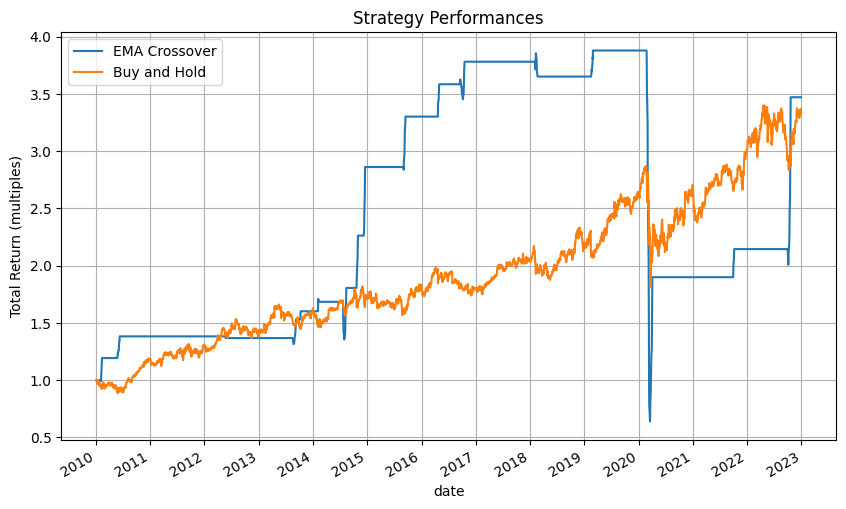

In [35]:
# visualize the performance of the strategy
ax = (strategy.loc[start_date:end_date].returns + 1).cumprod().plot(kind='line', label='EMA Crossover', title='Strategy Performances', ylabel='Total Return (multiples)', figsize=(10,6))
(np.exp(strategy.loc[start_date:end_date].log_return.cumsum())).plot(kind='line', label='Buy and Hold', grid=True, ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # set ticks for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # format of the year label
plt.legend(loc='upper left');

### Strategy 4: Machine Learning + Technical Indicators

Improvement of Strategy 1. The signal EMA(21) > EMA(50) will be the condition for the model to be applied as a filter.
The model learns the validity of the signal from other technical indicator and features such as normalised volumes, bollinger bands, distance between prices from the bounds of the bollinger bands etc.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [46]:
# create features (independent variables) and target (dependent variable)
strategy = data[DEFAULT_COLUMNS +
    [ 
        'log_return',
        'ema_5', 'ema_10', 'ema_21','ema_50',
        'rsi_14',
        'adx_14',
        'norm_volume_5','norm_volume_10','norm_volume_21',
        'bb_5_lb', 'bb_5_ub', 'bb_5_mb', 'bb_5_bw', 'bb_5_p'
    ]
].dropna()

strategy['x1'] = strategy['bb_5_ub'] - strategy['close']
strategy['x2'] = strategy['close'] - strategy['bb_5_mb']
strategy['x3'] = strategy['close'] - strategy['bb_5_lb'] 
strategy['x4'] = strategy['close'] - strategy['ema_10']
strategy['x5'] = strategy['ema_10'] - strategy['ema_21']
strategy['x6'] = strategy['ema_21'] - strategy['ema_50']

# create target variable to predict - idea is that since the default strategy would not be 100% accurate
# we will use the machine learning model to learn and filter out the signals using information from other indicators
K = 7 # using the same K=7 as before
RSI_K = 14

strategy['signal'] = (
    strategy['ema_21'] > strategy['ema_50']
).astype(np.int32)
strategy['returns'] = np.exp(strategy['signal'] * strategy['log_return'].rolling(K).sum().shift(-K)) - 1
strategy.dropna(inplace=True)

dataset = strategy[strategy.signal == 1].copy()
dataset['target'] = (dataset.returns > 0).astype(np.int32)

# train-test split
TRAIN_END = '2022-12-31' # define last period of training date
TEST_PERIOD_WEEKS = 52
TEST_START = str((pd.to_datetime(TRAIN_END) + pd.Timedelta(value=TEST_PERIOD_WEEKS, unit='W')).date())
train = dataset.loc[:TRAIN_END]
test = dataset.loc[TEST_START:]

# train the model 
FEATURES = ['rsi_14', 'adx_14', 'bb_5_bw', 'bb_5_p','norm_volume_5', 'norm_volume_10','x1', 'x2', 'x3', 'x4', 'x5', 'x6']
train_X, train_y = train[FEATURES], train['target']
model = RandomForestClassifier() # instantiate the model 
model.fit(train_X, train_y) # this api call trains the model

RandomForestClassifier()

In [47]:
# evaluate the model accuracy
test_X, test_y = test[FEATURES], test['target']
y_pred = model.predict(test_X)
acc = accuracy_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)

print(f"Model Accuracy: {acc*100:.2f}%")
# print(f"Model F1-Score: {f1:.2f}")

Model Accuracy: 65.15%


In [40]:
# without using model
out_of_sample_without_model = strategy[strategy.signal == 1].loc[TEST_START:]
metric_utils.strategy_peformance(out_of_sample_without_model)

=========================== STRATEGY PERFORMANCE ===========================
Trades: 132
'Up' days: 73 (55.30%)
'Down' days: 59 (44.70%)
Total Return: 69.77%
Annualised Volatility: 29.40%
Maximum Drawdown: -22.24%
Profit Factor: 1.669
Average Profit: 0.018
Average Loss: 0.013
Strategy performance dict = {'trades': '132', 'up_days': '73', 'up_days_percentage': '55.30', 'down_days': '59', 'down_days_percentage': '44.70', 'total_return': '69.77', 'annualised_volatility': '29.40', 'maximum_drawdown': '-22.24', 'profit_factor': '1.669', 'average_profit': '0.018', 'average_loss_display': '0.013'}


{'trades': '132',
 'up_days': '73',
 'up_days_percentage': '55.30',
 'down_days': '59',
 'down_days_percentage': '44.70',
 'total_return': '69.77',
 'annualised_volatility': '29.40',
 'maximum_drawdown': '-22.24',
 'profit_factor': '1.669',
 'average_profit': '0.018',
 'average_loss_display': '0.013'}

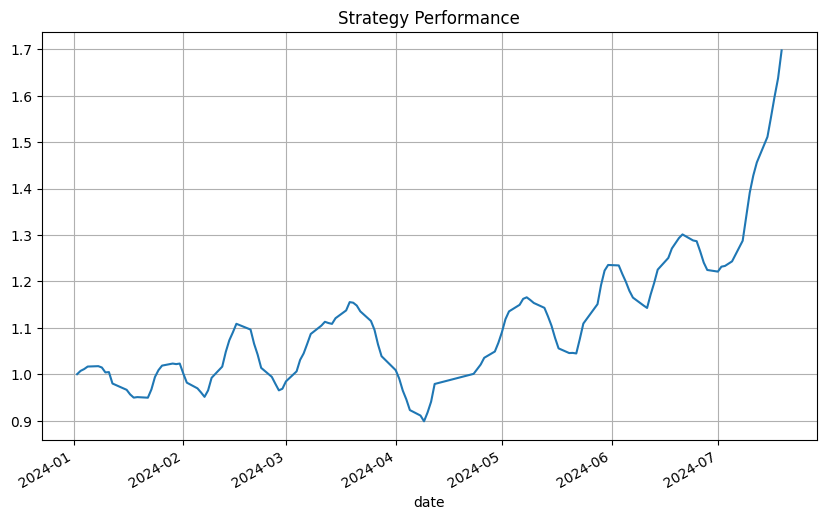

In [41]:
# visualize the performance of the strategy without using model
(out_of_sample_without_model.returns + 1).cumprod().plot(kind='line', grid=True, title='Strategy Performance', figsize=(10,6));

In [48]:
# strategy performance using the model
# notice the large decrease in maximum drawdown, the model was able to filter our drastic false signals
# winning rate has also improved a lot
out_of_sample_with_model = strategy[strategy.signal == 1].loc[TEST_START:].copy()
out_of_sample_with_model['signal'] = y_pred
out_of_sample_with_model = out_of_sample_with_model[out_of_sample_with_model.signal == 1]
metric_utils.strategy_peformance(out_of_sample_with_model)

=========================== STRATEGY PERFORMANCE ===========================
Trades: 69
'Up' days: 48 (69.57%)
'Down' days: 21 (30.43%)
Total Return: 68.79%
Annualised Volatility: 27.38%
Maximum Drawdown: -9.17%
Profit Factor: 2.900
Average Profit: 0.017
Average Loss: 0.013
Strategy performance dict = {'trades': '69', 'up_days': '48', 'up_days_percentage': '69.57', 'down_days': '21', 'down_days_percentage': '30.43', 'total_return': '68.79', 'annualised_volatility': '27.38', 'maximum_drawdown': '-9.17', 'profit_factor': '2.900', 'average_profit': '0.017', 'average_loss_display': '0.013'}


{'trades': '69',
 'up_days': '48',
 'up_days_percentage': '69.57',
 'down_days': '21',
 'down_days_percentage': '30.43',
 'total_return': '68.79',
 'annualised_volatility': '27.38',
 'maximum_drawdown': '-9.17',
 'profit_factor': '2.900',
 'average_profit': '0.017',
 'average_loss_display': '0.013'}

In [86]:
# utils.benchmark_performance(spy, '2024-01-01', '2024-07-20') # and we kind of beat the index as well

In [49]:
strategy['signal'] = 0
for datetime in out_of_sample_with_model.index:
    strategy.at[datetime, 'signal'] = 1

In [50]:
metric_utils.visualise_pricechart(strategy, start=str(test.index[0].date()), end=str(test.index[-1].date()), indicators=[], signal_marker=True)

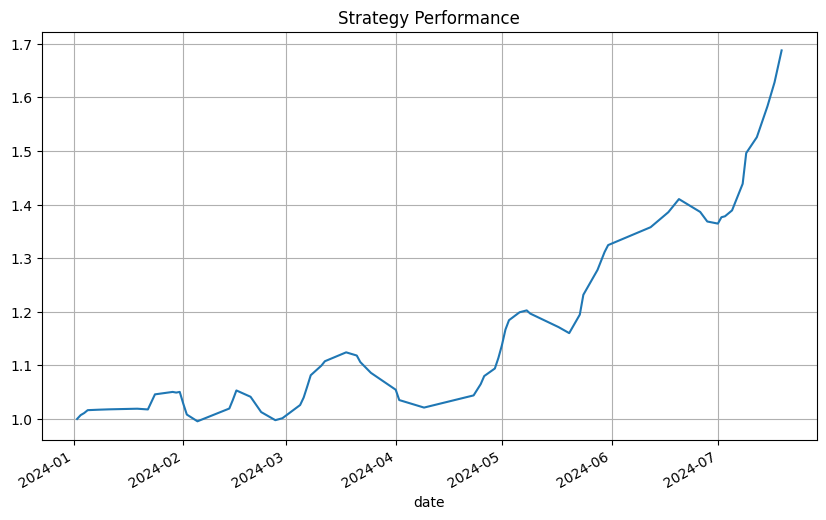

In [51]:
# visualize the performance of the strategy using model - notice the fewer sharp drops throughout the period
(out_of_sample_with_model.returns + 1).cumprod().plot(kind='line', grid=True, title='Strategy Performance', figsize=(10,6));

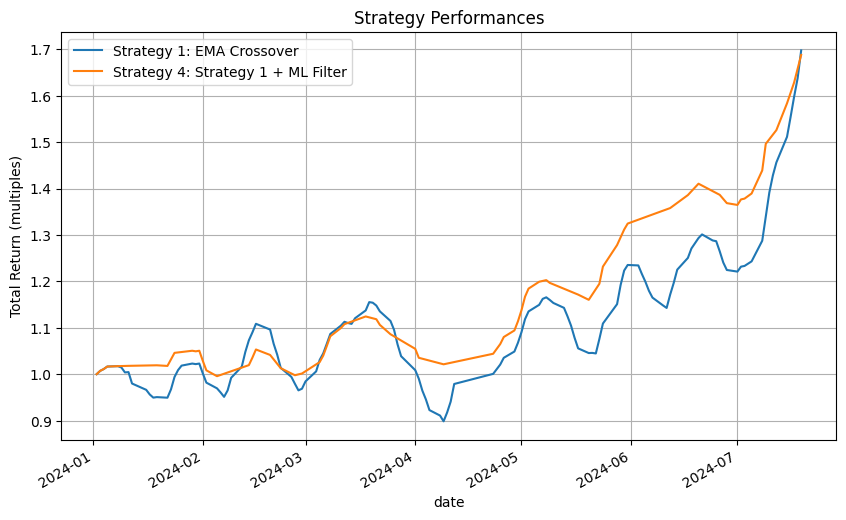

In [52]:
ax = (out_of_sample_without_model.returns + 1).cumprod().plot(kind='line', label='Strategy 1: EMA Crossover', title='Strategy Performances', ylabel='Total Return (multiples)', figsize=(10,6))
(out_of_sample_with_model.returns + 1).cumprod().plot(kind='line', label='Strategy 4: Strategy 1 + ML Filter', grid=True, ax=ax)
# ax.xaxis.set_major_locator(mdates.YearLocator())  # set ticks for each year
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # format of the year label
plt.legend(loc='upper left');

### Simple Price Chart Visualisation

In [175]:
# # TO BE REFINED LATER ON IF NEED BE:

# # Create subplots: 2 rows, 1 column with shared x-axis
# fig = make_subplots(
#     rows=2, cols=1,
#     shared_xaxes=True,
#     vertical_spacing=0.1,
#     row_heights=[0.7, 0.3],  # Relative heights of the subplots
#     subplot_titles=[f'Candlestick with SMA for {TICKER}', 'RSI and ADX']
# )

# # Add candlestick trace to the first row
# fig.add_trace(
#     go.Candlestick(
#         x=data.index,
#         open=data['open'],
#         high=data['high'],
#         low=data['low'],
#         close=data['close'],
#         name='Candlestick'
#     ),
#     row=1, col=1
# )

# # Add moving average trace to the first row
# fig.add_trace(
#     go.Scatter(
#         x=data.index,
#         y=data['sma_10'],
#         mode='lines',
#         name='SMA(10)',
#         line=dict(color='green', width=1)
#     ),
#     row=1, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=data.index,
#         y=data['sma_21'],
#         mode='lines',
#         name='SMA(21)',
#         line=dict(color='blue', width=1)
#     ),
#     row=1, col=1
# )

# # Add RSI trace to the second row
# fig.add_trace(
#     go.Scatter(
#         x=data.index,
#         y=data['rsi_7'],
#         mode='lines',
#         name='RSI 7',
#         line=dict(color='purple', width=2)
#     ),
#     row=2, col=1
# )

# # # Add ADX trace to the second row
# fig.add_trace(
#     go.Scatter(
#         x=data.index,
#         y=data['adx_14'],
#         mode='lines',
#         name='ADX 14',
#         line=dict(color='green', width=2)
#     ),
#     row=2, col=1
# )

# # Update layout for the subplots
# fig.update_layout(
#     title=f'OHLC with SMA and Indicators for {TICKER}',
#     xaxis2_title='Date',  # Title for the second subplot's x-axis
#     yaxis=dict(title='OHLC'),
#     width=1200,
#     height=800,
#     yaxis2=dict(title='RSI & ADX (0-100)', range=[0, 100]),  # Set the y-axis range for RSI and ADX
#     xaxis_rangeslider_visible=False,  # Hide range slider
#     legend=dict(x=0.01, y=0.99)
# )
# fig.show()